Viscoelastoplasticity in simple shear
======

The viscoelastic rheology outlined previously can be extended to a viscoelastoplastic rheology. This is achieved by parameterising brittle behaviour using a non-linear effective viscosity when stresses exceed a maximum yield strength, discussed in depth by [Moresi et al, 2003](http://www.sciencedirect.com/science/journal/00219991/184/2?sdc=1). 

Given that the deformation rate, $D_{ij}$, is the sum of the viscous, elastic and plastic parts, 

$$ D_{ij} = D^v_{ij} + D^e_{ij} + D^p_{ij} = \frac{\tau_{ij}}{2\eta} + \frac{\dot\tau_{ij}}{2\mu} + \lambda\frac{\tau_{ij}}{2|\tau|}$$

where $v$, $e$ and $p$ signify the viscous, elastic and plastic components of strain rate, $\tau$ is stress, $\eta$ shear viscosity, $\mu$ shear modulus, $\lambda$ a parameter to be determined such that the stress remains on the yield surface, and $|\tau| \equiv (\tau_{ij}\tau_{ij}/2)^{1/2}$. The plastic flow rule introduces non-linearity to the constitutive law, and will generally require iteration to find an equilibrium state.

The effective viscosity for yielded material can be found as for the viscoelastic case, by writing $\dot\tau$ as a finite difference, substituting into the strain rate equation and solving for $\tau$. Resulting is a stress history term given by,

$$\tau^t = \eta_{eff}\Big(2D^t + \frac{1}{\mu\Delta t_e}\tau^{t-1}\Big)$$

with an effective viscosity, $\eta_{eff}$, at yielding, $|\tau| = \tau_{yield}$, of

$$ \eta_{eff} = \frac{\eta\tau_y\Delta t_e\mu}{\eta\tau_y+\tau_y\Delta t_e\mu+\lambda\eta\Delta t_e\mu}$$

Alternatively, the effective viscosity for yielded material can be found directly using 

$$\eta_{eff} = \tau_{yield} / |D_{eff}|$$

with $|D| = (D_{ij}D_{ij}/2)^{1/2}$ and 

$$D_{eff} = 2D^t + \frac{1}{\mu\Delta t_e}\tau^{t-1}$$



The iteration of $\eta$ is repeated until the velocity solution is unchanged to within an error tolerance required for the solution as a whole.

**Simple shear in two dimensions**

This notebook models a viscoelastoplastic material, with a maximum yield strength of $\tau_y = 2.0 Pa$, undergoing simple shear in two dimensions. The vertical velocity boundary conditions are periodic, the bottom velocity bc is no-slip with a horizontal shear velocity bc applied to the top wall until $t = \alpha$.  For $t > \alpha$ the top wall velocity is taken to zero with the stored elastic stress allowed to relax.

In [1]:
import UWGeodynamics as GEO

loaded rc file /Users/rfarrington/Underworld/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

# Analysis

In [3]:
eta     = 1e22 * u.pascal * u.second # Viscosity
mu      = 10e9 * u.pascal # Shear Modulus

alpha = eta / mu         # Relaxation time
dt_e    = 20e3 * u.year  # observation time
eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # effective viscosity

yieldStrength = 12e6 * (u.kilogram * u.meter**-1 * u.second**-2)

minVisc = 1e19 * (u.kilogram * u.meter**-1 * u.second**-2) * u.second
maxVisc = 1e24  * (u.kilogram * u.meter**-1 * u.second**-2) * u.second

density = 2700 * u.kilogram / u.metre**3
gravity = 9.81 * u.metre / u.second**2

shearVelocity = 0.5 * u.centimetre / u.year

print 'Relaxation time = ', alpha.to(u.years)

Relaxation time =  31688.7646408 year


# Scaling

In [4]:
model_height = 100. * u.kilometer
bodyforce = density * gravity

KL = model_height 
Kt = alpha
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [5]:
Model = GEO.Model(elementRes=(16, 16),
                  minCoord=(0., 0.),
                  maxCoord=(model_height, model_height),
                  periodic=[True, False])

In [6]:
Model.outputDir="ViscoElastoPlasticShear"

## Materials

In [7]:
viscoelastic = Model.add_material(name="Visco Elastic", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
viscoelasticBar = Model.add_material(name="Visco Elastic Bar", shape=GEO.shapes.Box(minX=40. * u.kilometer,
                                                                                    maxX=60. * u.kilometer,
                                                                                    top=Model.top,
                                                                                    bottom=Model.bottom))


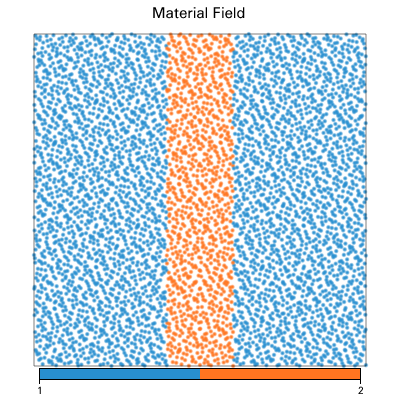

In [8]:
Fig = Model.plot.material(figsize=(400,400), fn_size=5.)

### Densities

In [9]:
viscoelastic.density = density
viscoelasticBar.density = density

### Viscosities

In [10]:
viscoelastic.viscosity = eta
viscoelasticBar.viscosity = eta

### Plasticity

In [11]:
viscoelastic.plasticity    = GEO.VonMises(cohesion=yieldStrength)
viscoelasticBar.plasticity = GEO.VonMises(cohesion=yieldStrength)

Model.minViscosity = minVisc 
Model.maxViscosity = maxVisc 

### Elasticity

In [12]:
viscoelastic.elasticity = GEO.Elasticity(shear_modulus= mu,
                                         observation_time= dt_e)
viscoelasticBar.elasticity = GEO.Elasticity(shear_modulus= mu,
                                         observation_time= dt_e)

## Velocity Boundary conditions

In [13]:
Model.set_velocityBCs(top=[shearVelocity, 0], bottom=[0, 0])

In [14]:
GEO.rcParams["solver"] = "lu"

In [15]:
tTracer      = [GEO.nd(Model.time)]
previousStress_xy  = [0.]
totalStress_xy  = [0.]

def postSolveHook():
    global tTracer, previousStress_xy, totalStress_xy
    tTracer.append(GEO.nd(Model.time))
    previousStress_xy.append(
        Model._previousStressField[2].evaluate(Model.swarm)[0])
    totalStress_xy.append(        
        Model._stressFn[2].evaluate(Model.swarm)[0])


In [16]:
Model.postSolveHook = postSolveHook

In [17]:
# shear material for 0 < t < alpha
Model.run_for(alpha)

Time:  2.10379506498e+11 second dt: 2.10379506498e+11 second
Time:  4.20759012996e+11 second dt: 2.10379506498e+11 second
Time:  6.31138519494e+11 second dt: 2.10379506498e+11 second
Time:  8.41518025992e+11 second dt: 2.10379506498e+11 second
Time:  1e+12 second dt: 1.58481974008e+11 second


1

In [18]:
# set top wall BC to no slip
Model.set_velocityBCs(top=[0., 0], bottom=[0, 0])

In [19]:
Model.run_for(7.*alpha)

Time:  1.2103795065e+12 second dt: 2.10379506498e+11 second
Time:  1.420759013e+12 second dt: 2.10379506498e+11 second
Time:  1.63113851949e+12 second dt: 2.10379506498e+11 second
Time:  1.84151802599e+12 second dt: 2.10379506498e+11 second
Time:  2.05189753249e+12 second dt: 2.10379506498e+11 second
Time:  2.26227703899e+12 second dt: 2.10379506498e+11 second
Time:  2.47265654549e+12 second dt: 2.10379506498e+11 second
Time:  2.68303605198e+12 second dt: 2.10379506498e+11 second
Time:  2.89341555848e+12 second dt: 2.10379506498e+11 second
Time:  3.10379506498e+12 second dt: 2.10379506498e+11 second
Time:  3.31417457148e+12 second dt: 2.10379506498e+11 second
Time:  3.52455407798e+12 second dt: 2.10379506498e+11 second
Time:  3.73493358447e+12 second dt: 2.10379506498e+11 second
Time:  3.94531309097e+12 second dt: 2.10379506498e+11 second
Time:  4.15569259747e+12 second dt: 2.10379506498e+11 second
Time:  4.36607210397e+12 second dt: 2.10379506498e+11 second
Time:  4.57645161047e+12 se

1

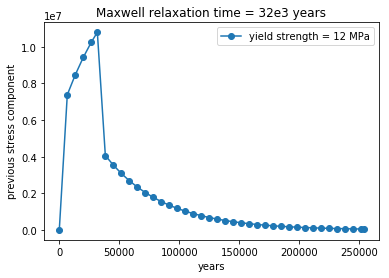

In [27]:
import pylab as plt
plt.plot(GEO.Dimensionalize(tTracer, u.years), GEO.Dimensionalize(totalStress_xy, u.pascal), 
         label='yield strength = 12 MPa', marker='o')
plt.xlabel('years')
plt.ylabel('previous stress component')
plt.title('Maxwell relaxation time = 32e3 years')
plt.legend(loc='best')

plt.show()


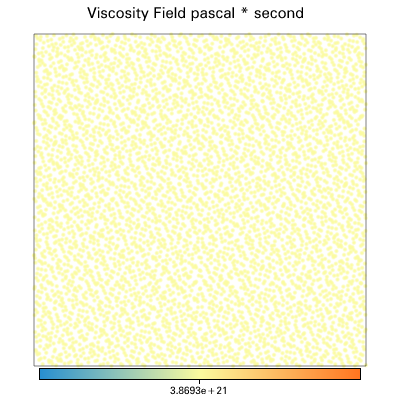

In [28]:
Fig = Model.plot.viscosity(figsize=(400,400), fn_size=5., logScale=True)